## Demo of the UniRes Forward Model

This notebook applies the forward model of UniRes (x = Ay + n) to an 'ideal' MR image from the BrainWeb simulator [1], generating a degraded, low-resolution (LR) image (x). The LR image is then reconstructed (y_hat) using either a simple trilinear reslice, or using the UniRes super-resolution algorithm. For each reconstruction method, the SSIM metric is computed between the reference (y) and the reconstruction (y_hat).

1. https://brainweb.bic.mni.mcgill.ca/

### Requirements
```sh
pip install scikit-image
```


In [ ]:
from nitorch.plot import show_slices
from nitorch import io
import torch
from unires._project import (_proj_apply, _proj_info)
from unires.struct import settings
from unires.run import preproc
from skimage.metrics import structural_similarity as ssim

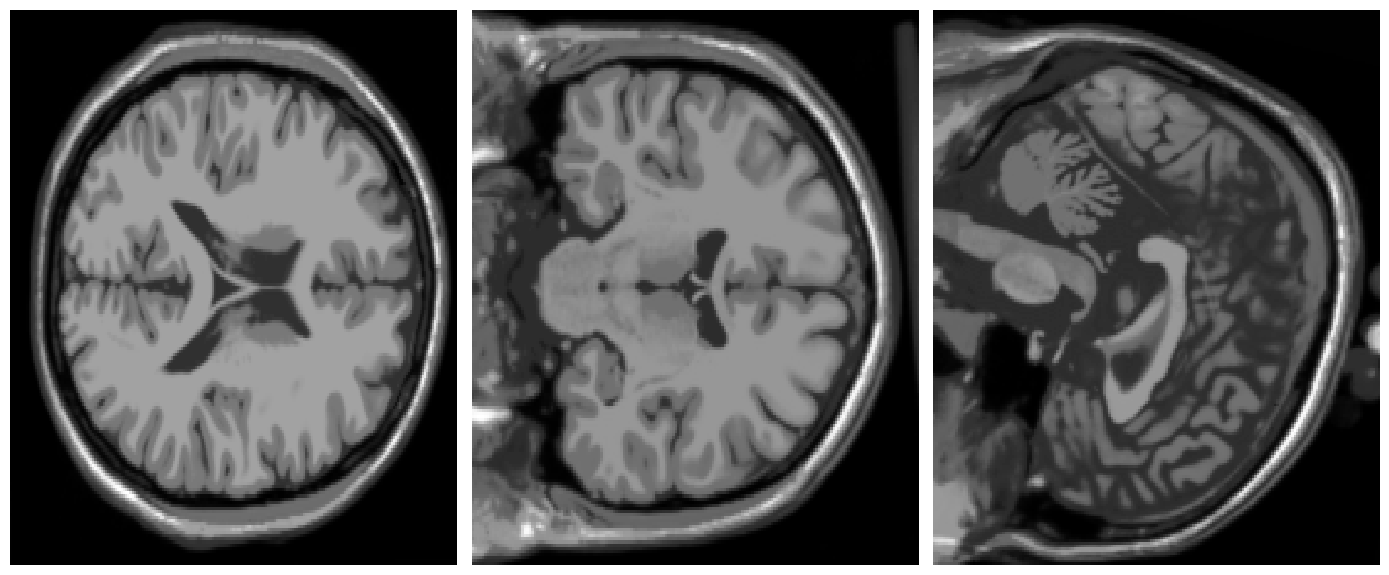

In [ ]:
# Load image
pth = "../data/t1_icbm_normal_1mm_pn0_rf0.nii.gz"
nii_y = io.map(pth)
y = nii_y.fdata()

# Visualise
fig = show_slices(y, figsize=(14, 6))

dim_y=tensor([181., 217., 181.], dtype=torch.float64)
dim_x=tensor([181., 217.,  45.], dtype=torch.float64)


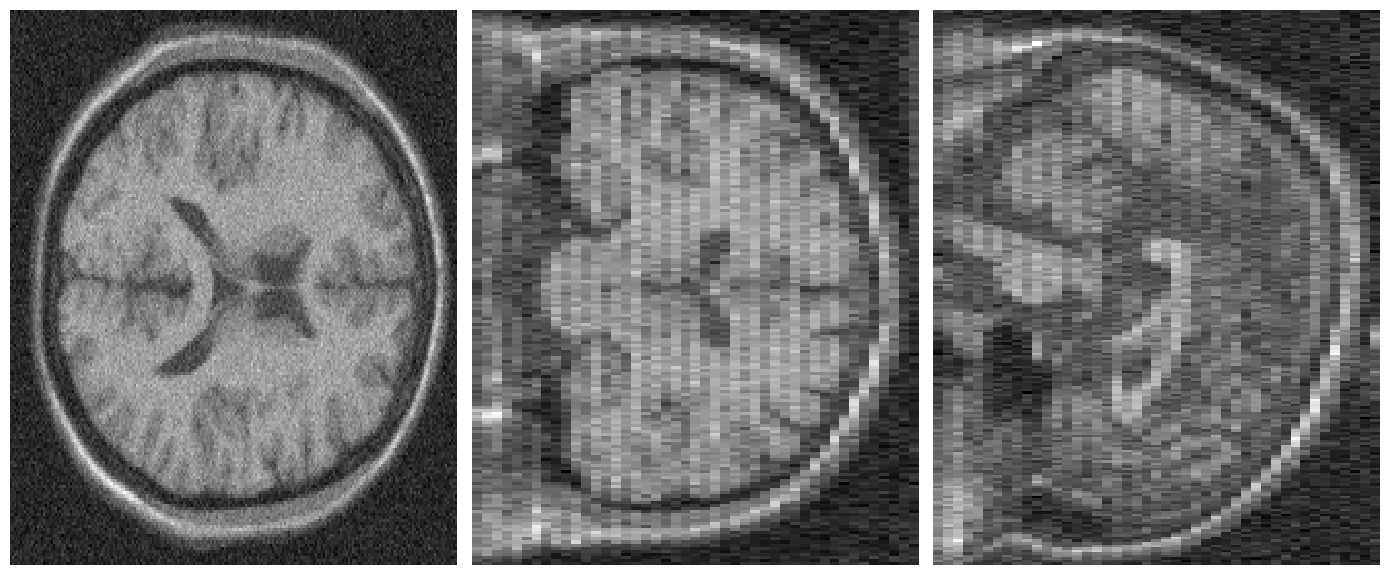

In [ ]:
# Apply UniRes forward model to BrainWeb MRI (y = Ax + n)

# Parameters
# https://github.com/brudfors/UniRes/blob/master/unires/struct.py#L57
vx_scl = torch.tensor((1, 1, 4))  # scaling of the voxel sizes to create the low-res image
prof_ip = 0  # (0=rect|1=tri|2=gauss)
prof_tp = 0  # (0=rect|1=tri|2=gauss)
s_gap = 0.0  # slice gap
device = "cuda"  # GPU or CPU
eo_scl = 0.1  # even/odd slice scaling
rigid = torch.eye(4)  # rigid transformation
std_noise = 75 # std of Gaussian noise

# Set output field of view
mat_y = nii_y.affine
dim_y = torch.as_tensor(y.shape, dtype=mat_y.dtype)
scl = torch.as_tensor(torch.cat((vx_scl, torch.ones(1))), dtype=mat_y.dtype)
mat_scl = torch.diag(scl)
mat_x = mat_y.mm(mat_scl)
dim_x = mat_scl[:3, :3].inverse().mm(dim_y[:, None]).floor().squeeze()
print(f"dim_y={dim_y}")
print(f"dim_x={dim_x}")

# Set device
mat_x = mat_x.to(device)
mat_y = mat_y.to(device)
dim_y = dim_y.to(device)
dim_x = dim_x.to(device)
y = y.to(device)

# Create projection operator
po = _proj_info(
    dim_y, mat_y, dim_x, mat_x, 
    rigid=rigid, prof_ip=prof_ip, prof_tp=prof_tp, 
    gap=s_gap, device=device, scl=eo_scl
)
A = lambda y: _proj_apply("A", y[None, None, ...], po)[0, 0, ...]
n = std_noise*torch.randn(dim_x.cpu().type(torch.int).tolist(), device=device)

# Apply forward model A
x = A(y) + n

# Visualise results
fig = show_slices(x, figsize=(14, 6))

In [ ]:
# Run UniRes with unified super-resolution

# Set input data
data = [[x, mat_x]]

# Settings
s = settings()
s.write_out = False
s.reg_scl = 1e0
s.pow = dim_y.cpu().type(torch.int).tolist()
# Run algorithm
y_hat, _, _ = preproc(data, sett=s)
y_hat = y_hat[..., 0]


  _   _       _ ____           
 | | | |_ __ (_)  _ \ ___  ___ 
 | | | | '_ \| | |_) / _ \/ __|
 | |_| | | | | |  _ <  __/\__ \
  \___/|_| |_|_|_| \_\___||___/

27/04/2023 16:16:16 | GPU: NVIDIA RTX A6000, CUDA: True, PyTorch: 2.0.0

Input
c=0, n=0 | fname=None

Estimating model hyper-parameters... completed in 0.21781 seconds:
c=0 | tau= 0.0001597 | sd=     79.13 | mu=     441.7 | ct=False 

Mean space | dim=(181, 217, 181), vx=(1.0, 1.0, 1.0)

ADMM step-size=5.5823

Starting super-resolution (update_rigid=False, update_scaling=True) 
 | C=1 | N=1 | device=cuda | max_iter=512 | tol=0.0001 | sched_num=0
  0 - Convergence ( 0.2 s)  | nlyx =  1.546e+06, nlxy =  6.057e+05, nly =  9.402e+05, gain =        inf
  1 - Convergence ( 0.2 s)  | nlyx =  1.444e+06, nlxy =  8.017e+05, nly =   6.42e+05, gain =  1.0000000
  2 - Convergence ( 0.2 s)  | nlyx =  1.369e+06, nlxy =  6.959e+05, nly =  6.729e+05, gain =  0.4232157
  3 - Convergence ( 0.2 s)  | nlyx =  1.348e+06, nlxy =  6.596e+05, nly =  6

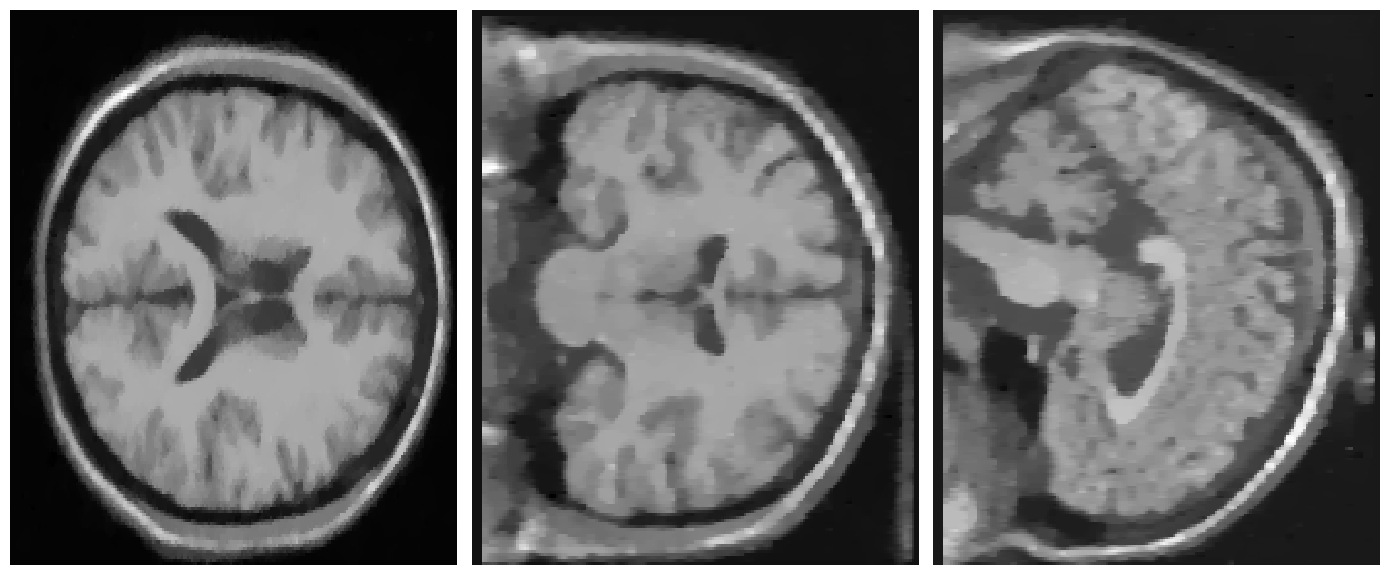

In [ ]:
# Visualise results
fig = show_slices(y_hat, figsize=(14, 6))

In [ ]:
# Compute SSIM
data_range = (y_hat.max() - y_hat.min()).cpu().numpy()
ssim_sr = ssim(y.cpu().numpy(), y_hat.cpu().numpy(), data_range=data_range)
print(f"SSIM(y, y_hat)={ssim_sr}")

SSIM(y, y_hat)=0.5113608300214716


In [ ]:
# Run UniRes with trilinear reslice

# Settings
s = settings()
s.write_out = False
s.max_iter = 0  # setting the number of iterations to zero makes UniRes use trilinear reslice (instead of super-res)
s.pow = dim_y.cpu().type(torch.int).tolist()
# Run algorithm
y_hat, _, _ = preproc(data, sett=s)
y_hat = y_hat[..., 0]


  _   _       _ ____           
 | | | |_ __ (_)  _ \ ___  ___ 
 | | | | '_ \| | |_) / _ \/ __|
 | |_| | | | | |  _ <  __/\__ \
  \___/|_| |_|_|_| \_\___||___/

27/04/2023 16:16:36 | GPU: NVIDIA RTX A6000, CUDA: True, PyTorch: 2.0.0

Input
c=0, n=0 | fname=None

Mean space | dim=(181, 217, 181), vx=(1.0, 1.0, 1.0)
UniRes-output


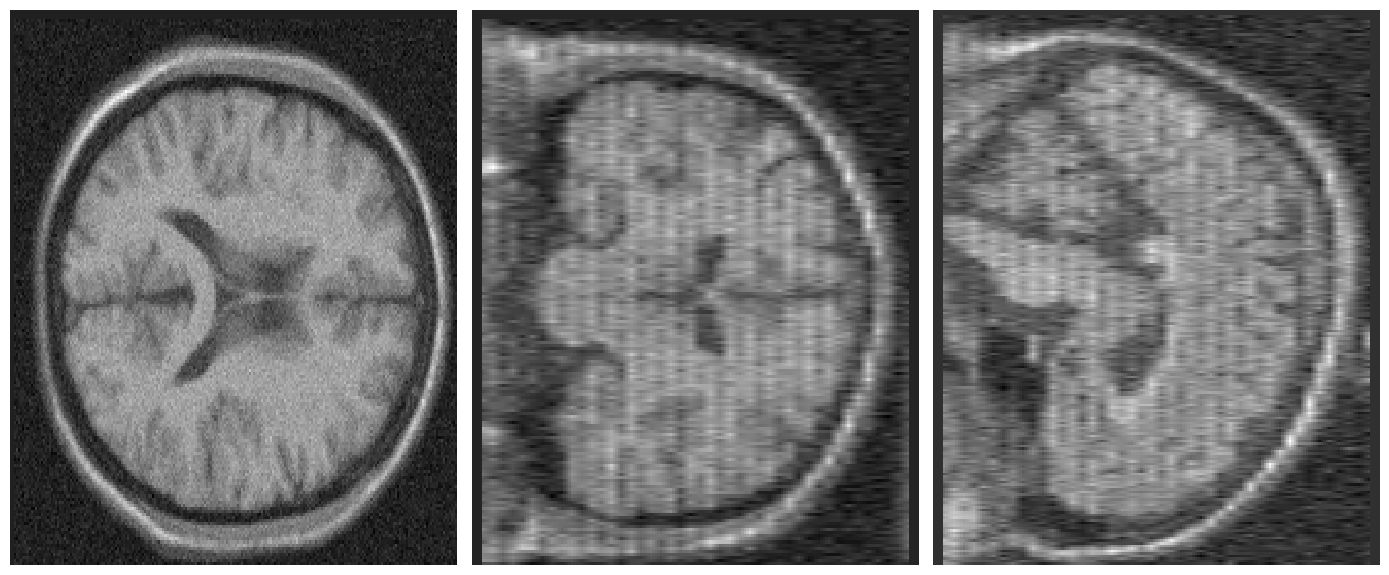

In [ ]:
# Visualise results
fig = show_slices(y_hat, figsize=(14, 6))

In [ ]:
# Compute SSIM
data_range = (y_hat.max() - y_hat.min()).cpu().numpy()
ssim_sr = ssim(y.cpu().numpy(), y_hat.cpu().numpy(), data_range=data_range)
print(f"SSIM(y, y_hat)={ssim_sr}")

SSIM(y, y_hat)=0.3222284086205195
